# Writeup / README
###  Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.

You are reading it

In [1]:
# import necessary modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline


# Rubric 1 : Camera Calibration
## Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

Following code used python's cv2 library to calibrate camera distortion. Basically, all heavy lifting is done by the cv2 functions findChessboardCorners, drawChessboardCorners, calibrateCamera and undistort.

I provided number of corners (9,5 in this case) to findChessboardCorners(), which calculates actual position of the corners in the image. To compute distortion parameters/coefficients, I passed the actual and ideal (object) points to calibrateCamera() function. Using these coefficients an image can be undistorted.

Following cell perform these operations:

In [2]:
# set number of corner points to be found
nx, ny = 9,5

cameraCalibrationDirectory = './camera_cal/'
fname = cameraCalibrationDirectory+ 'calibration1.jpg'
img = cv2.imread(fname)
imageShape = img.shape
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
objpoints, imgpoints = [],[]
# If found, draw corners
if ret == True:
    # add image points and object points
    imgpoints.append(corners)
    objpoints.append(objp)
    # Draw and display the corners
    imgWithCorners =np.copy(img)
    cv2.drawChessboardCorners(imgWithCorners, (nx, ny), corners, ret)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)    

Follwoing is an example of distarted vs undestored image

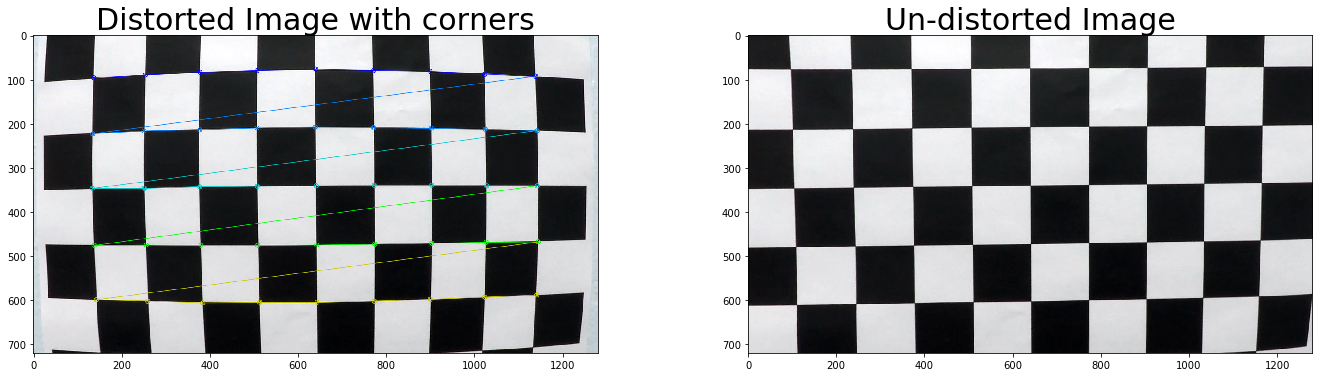

In [3]:
fig, axis = plt.subplots(1,2,figsize=(20,5))
fig.tight_layout()

axis[0].imshow(imgWithCorners)
axis[0].set_title('Distorted Image with corners', fontsize=30)

# undistort image
undist = cv2.undistort(img, mtx, dist, None, mtx)
    
# plot undistorted image
axis[1].imshow(undist)
axis[1].set_title('Un-distorted Image', fontsize=30)
plt.show()

# Rubric 2 : Undistort a test image
## Provide an example of a distortion-corrected image.

The following images demonstrate undistortion.

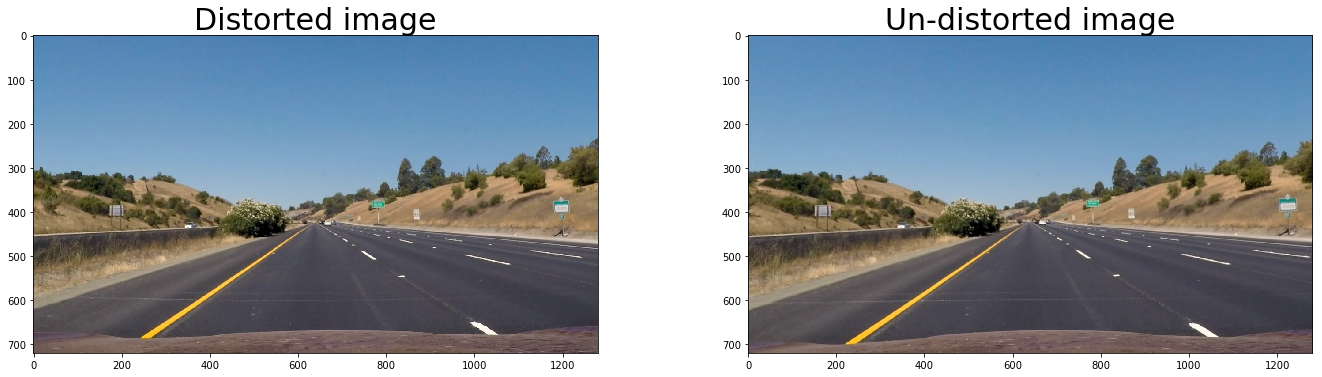

In [4]:
# remove distortion from a test image

testimg=mpimg.imread('./test_images/straight_lines1.jpg')
testimg1=mpimg.imread('./test_images/straight_lines1.jpg')
testimg2=mpimg.imread('./test_images/straight_lines2.jpg')
fig, axis = plt.subplots(1,2, figsize=(20,5))
fig.tight_layout()
axis[0].imshow(testimg)
axis[0].set_title('Distorted image', fontsize=30)
undisttestimg=cv2.undistort(testimg, mtx,dist, None, mtx)
axis[1].imshow(undisttestimg)

axis[1].set_title('Un-distorted image', fontsize=30)
plt.show()

The effect of undistort is minute, however, observable. e.g. the shape of the car's hood has changed.

# Rubric 3 : Create binary image
## Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

After experimenting with different gradients and colour channels, I have used 
1. S channel from HLS colour space
2. Sobel operator in x direction 
3. L channel from LUV colour space
4. B channel from Lab colour space

to compute the binary map.

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def lab_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = hls[:,:,2]
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output

def luv_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = hls[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Convert to HLS color space and separate the V channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #l_channel = hls[:,:,1]
    #s_channel = hls[:,:,2]
    # Sobel x
    #sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sobelx = abs_sobel_thresh(img,sx_thresh[0], sx_thresh[1])
    l_channel = luv_select(img, (210,255))
    b_channel = lab_select(img, (160,255))
    # Threshold color channel
    #s_binary = np.zeros_like(s_channel)
    #s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    s_binary = hls_select(img, s_thresh)
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.    
    combined_binary = np.zeros_like(sobelx)
    combined_binary[(s_binary == 1) | (sobelx == 1) | (l_channel==1) | (b_channel==1)] = 1
    return combined_binary

def colouredMap(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
        
    sobelx = abs_sobel_thresh(img,sx_thresh[0], sx_thresh[1])    
    
    s_binary = hls_select(img, s_thresh)
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sobelx), sobelx, s_binary)) * 255
    return color_binary

Follwoing is an example of binary map creation from a test image using S channel and Sobel operation in x direction.

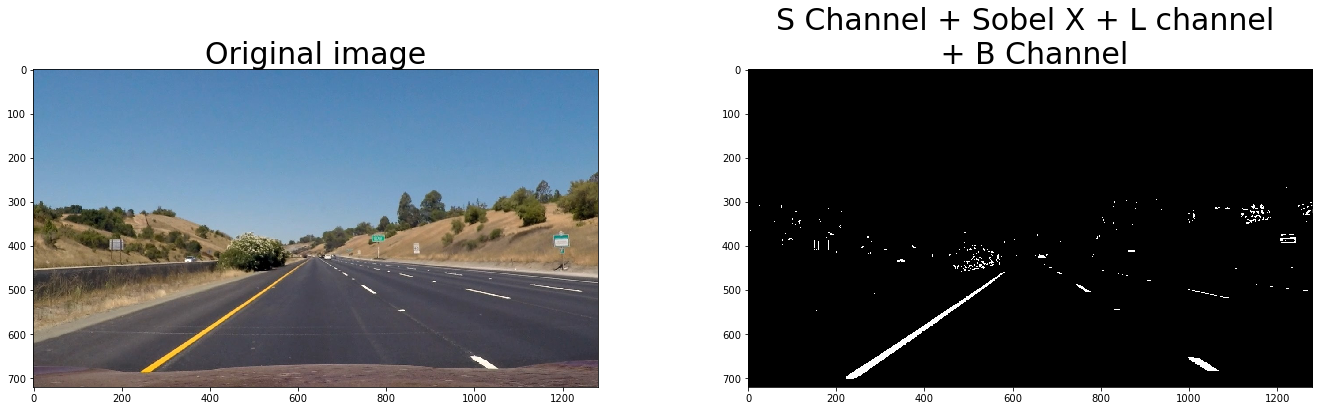

In [6]:
fig, axis = plt.subplots(1,2, figsize=(20,5))
fig.tight_layout()
axis[0].imshow(testimg)
axis[0].set_title('Original image', fontsize=30)
axis[1].imshow(pipeline(testimg), cmap='gray')
#undisttestimg=cv2.undistort(testimg, mtx,dist, None, mtx)
axis[1].set_title('S Channel + Sobel X + L channel \n + B Channel', fontsize=30)
plt.show()

In [7]:
# ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
#gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
#grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
#mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))


# Rubric 4: Perspective transformation
## Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

Follwoing code defines the source and destination points to create bird's eye view image. Here, cv2.getPerspectiveTransform() and cv2.warpPerspective() functions are used to compute transformation and apply perspective transformation to an image.

Also a test image is transformed.

I have chosen to hard code my source and destination points for perspective projection.

In [8]:
'''
some points to test with
275, 675
1045,675
585, 455
700, 455

210, 720
1100, 720
585, 455
700, 455
'''
src=np.array([[220, 720],[1120, 720],[650, 430],[620, 430]])
dest = np.array([[220, 720],[1120, 720],[1120, 1],[220, 1]]) # 430 in place of 1

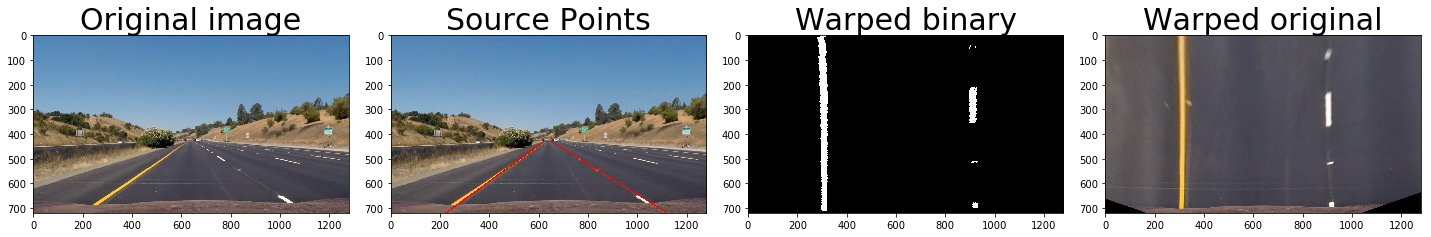

In [9]:
bottom_left, bottom_right, top_left, top_right  = [220,720], [1110, 720], [570, 470], [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

bottom_left, bottom_right, top_left, top_right = [320,720], [920, 720], [320, 1], [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])

testimg = mpimg.imread('./test_images/straight_lines1.jpg')
fig, axis = plt.subplots(1,4, figsize=(20,20))

fig.tight_layout()
axis[0].imshow(testimg)
axis[0].set_title('Original image', fontsize=30)
axis[1].imshow(cv2.polylines(testimg.copy(),[src],True,(255,0,0), thickness=4))
#undisttestimg=cv2.undistort(testimg, mtx,dist, None, mtx)

axis[1].set_title('Source Points', fontsize=30)

# get transformation coefficent
M = cv2.getPerspectiveTransform(source, dst)

# compute inverse transform to be used later
Minv = cv2.getPerspectiveTransform(dst,source)

# get binary image
binaryImage = pipeline(testimg)
warpedBW = cv2.warpPerspective(binaryImage, M, (imageShape[1], imageShape[0]) , flags=cv2.INTER_LINEAR)
axis[2].imshow(warpedBW,cmap='gray')
axis[2].set_title('Warped binary', fontsize=30)
warped2 = cv2.warpPerspective(testimg, M, (imageShape[1], imageShape[0]) , flags=cv2.INTER_LINEAR)
axis[3].imshow(warped2)
axis[3].set_title('Warped original', fontsize=30)
plt.show()

# Rubric 5:
## Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Base of a lane line is identified using a histogram of lower half of the image. The peaks signify presense of lanes.

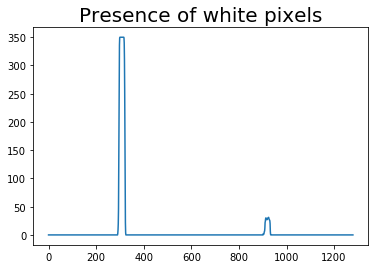

In [10]:
histogram = np.sum(warpedBW[warpedBW.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.title("Presence of white pixels", fontsize=20)
plt.show()

In [11]:
binary_warped = warpedBW

Following code identifies the pixels of the lane by sliding window algorithm. It starts at the base, finds next window in which at least minpix number of bright pixels are found. This practically finds lane line pixels from bottom to the top.

In [12]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 80
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

Follwoing is an example of above code applied on a test image

(720, 0)

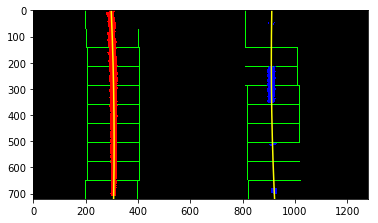

In [13]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#### Find new lanes from previously found lane lines

(720, 0)

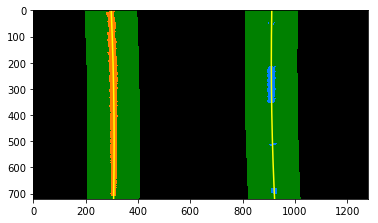

In [14]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Rubric 6: Radius of curvature & Vehicle position
## Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [15]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

11696.9680627 11114.138685


### Scale corrected radius of curvature

In [18]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
# print(leftx.shape, ploty.shape)
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius of curvature {:.2f} m'.format((left_curverad+right_curverad)*0.5))
# Example values: 632.1 m    626.2 m


Radius of curvature 3739.27 m


### Offset from center

In [19]:
# calculate offset of the car from the center
laneCenter = (left_fitx[-1] + right_fitx[-1])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
offetPixels = abs(imageShape[0]/2 - laneCenter)
offsetDistance = xm_per_pix*offetPixels
print("Center offset: {:.2f} m".format( offsetDistance))

Center offset: 1.35 m


# Rubric 7:
## Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Inverse warp

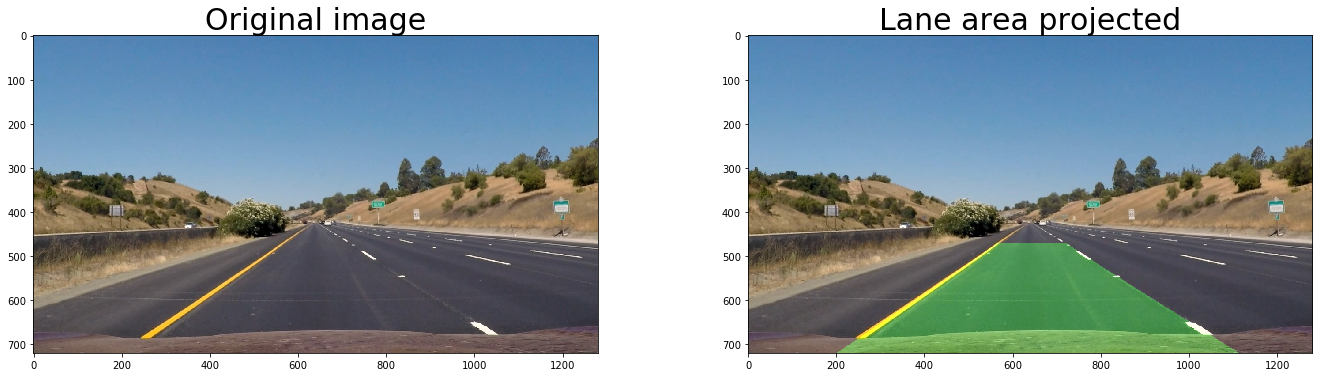

In [20]:
warped=binary_warped# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (imageShape[1], imageShape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(testimg, 1, newwarp, 0.3, 0)
fig, axis = plt.subplots(1,2, figsize=(20,5))
fig.tight_layout()
axis[0].imshow(testimg)
axis[0].set_title('Original image', fontsize=30)
axis[1].imshow(result)
axis[1].set_title('Lane area projected', fontsize=30)
plt.show()

# Rubric 8:
## Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!)

My pipeline performs well, when the lanes are bright and clear, and there is no vehicle in nearby lanes. However, when such conditions arise, the projected lanes are little wobbly.

I have taken running average of previous 15 lane lines, to reduce jitter in lane line projection.


The final video is produced in file 'lanesProjectedVideo.mp4'

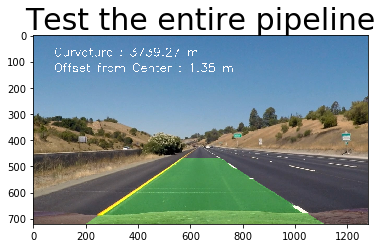

In [21]:
lastLeftX=[]
lastRightX=[]
MaxHistory = 15

def projectLanes(img):
    binary_image = pipeline(img)
    
    # warp to get bird's eye view
    binary_warped = cv2.warpPerspective(binary_image, M, (imageShape[1], imageShape[0]) , flags=cv2.INTER_LINEAR)
    
    ##
    ## Find lane line coordinates in "binary_warped"
    ##
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 80
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # take running averate of past MaxHistory items
    lastLeftX.append(left_fitx)
    lastRightX.append(right_fitx)
        
    if len(lastLeftX)>MaxHistory:
        lastLeftX.pop(0)
        lastRightX.pop(0)
        tlx = np.zeros_like(left_fitx)
        for i in range(MaxHistory):
            tlx = tlx + lastLeftX[i]
        left_fitx = tlx/MaxHistory
        
        tlx = np.zeros_like(right_fitx)
        for i in range(MaxHistory):
            tlx = tlx + lastRightX[i]
        right_fitx = tlx/MaxHistory
        
    
    ##
    ## project back on the coloured image
    ##
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imageShape[1], imageShape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # insert radius of curvature and offset from center onto the image
    # calculate offset of the car from the center
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    laneCenter = (left_fitx[-1] + right_fitx[-1])/2    
    offetPixels = abs(imageShape[0]/2 - laneCenter)
    offsetDistance = xm_per_pix*offetPixels
    #print("Center offset: {:.2f} m".format( offsetDistance))
    
    

    # Fit new polynomials to x,y in world space
    #print(ploty.size, left_fitx.size)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('Radius of curvature {:.2f} m'.format((left_curverad+right_curverad)*0.5))
    
    cv2.putText(result,"Curvature : {:.2f} m".format( (left_curverad+right_curverad)*0.5) , (80, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, "Offset from Center : {:.2f} m".format( offsetDistance), (80, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

result = projectLanes(testimg)

# for sanity check pass one image through the entire pipeline
plt.imshow(result)
plt.title('Test the entire pipeline', fontsize=30)
plt.show()
    

#### Process the project video and project green lane area
The final output of processing the project video can be found in 'lanesProjectedVideo.mp4'.

In [22]:
from moviepy.editor import VideoFileClip

processedVideoFileName = 'lanesProjectedVideo.mp4'
clip = VideoFileClip("./project_video.mp4")
processedVideo = clip.fl_image(projectLanes) 
%time processedVideo.write_videofile(processedVideoFileName, audio=False)

[MoviePy] >>>> Building video lanesProjectedVideo.mp4
[MoviePy] Writing video lanesProjectedVideo.mp4


100%|█████████▉| 1260/1261 [05:29<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lanesProjectedVideo.mp4 

Wall time: 5min 33s


In [23]:
# create a debug video

# Rubric 8: Discussion

I had some difficulty figuring out the correct source and destination points for transforming an image to bird's eye view.
Finding correctly lane lines when there is shadow on the road is little more difficult than bright lanes. In this case the saturation values start to dip.

I would love to come back and finish the challenge video.
